In [1]:
import json
import pescador
import glob
import os
import numpy as np
import medleydb as mdb

In [2]:
cd ../deepsalience/

/scratch/rmb456/multif0/deepsalience


In [3]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import librosa
import mir_eval
import numpy as np

import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, Lambda, Permute
from keras.layers.merge import Concatenate, Multiply
from keras.layers.convolutional import Conv2D
from keras.layers.wrappers import TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import os

import compute_training_data as C
import experiment_datasets
import evaluate
import core

Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4311810893966447181
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 2
}
incarnation: 12225197754843438791
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:85:00.0"
]


/home/rmb456/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [25]:
def get_grouped_data(json_path, mtrack_list):

    json_fpaths = glob.glob(os.path.join(json_path, '*.json'))

    XA_dat = []
    XB_dat = []
    XC_dat = []
    XD_dat = []

    for fpath in json_fpaths:

        track_id = '_'.join(os.path.basename(fpath).split('.')[0].split('_')[:2])
        if track_id not in mtrack_list:
            continue

        with open(fpath, 'r') as fhandle:
            dat = json.load(fhandle)

            for key in dat.keys():
                bname = os.path.basename(key).split('.')[0].split('_')
                if len(bname) == 4:
                    XA_dat.append([key, dat[key]])
                elif len(bname) == 6:
                    if bname[4] == 'resynth':
                        XB_dat.append([key, dat[key]])
                    elif bname[4] == 'noguitar':
                        XC_dat.append([key, dat[key]])
                    elif bname[4] == 'nosynth':
                        XD_dat.append([key, dat[key]])
                    else:
                        raise ValueError("bname[4] = {} not recognized".format(bname[4]))
                else:
                    raise ValueError("len(bname) = {} not recognized".format(len(bname)))

    return XA_dat, XB_dat, XC_dat, XD_dat


def grab_patch_output(f, t, n_f, n_t, y_data):
    """Get a time-frequency patch from an output file
    """
    return y_data[f: f + n_f, t: t + n_t][np.newaxis, :, :]


def grab_patch_input(f, t, n_f, n_t, x_data):
    """Get a time-frequency patch from an input file
    """
    return np.transpose(
        x_data[:, f: f + n_f, t: t + n_t], (1, 2, 0)
    )[np.newaxis, :, :, :]


def grab_empty_output(n_f, n_t):
    return np.zeros((1, n_f, n_t))


def multitask_patch_generator(fpath_in, dict_out, n_samples=20, input_patch_size=(360, 50)):
    """Generator that yields an infinite number of patches
       for a single input, output pair
    """
    data_in = np.load(fpath_in)
    data_out = {}
    for task in dict_out.keys():
        data_out[task] = np.load(dict_out[task])

    _, _, n_times = data_in.shape
    n_f, n_t = input_patch_size

    t_vals = np.arange(0, n_times - n_t)
    np.random.shuffle(t_vals)

    for t in t_vals[:n_samples]:
        f = 0
        t = np.random.randint(0, n_times - n_t)

        x = grab_patch_input(
            f, t, n_f, n_t, data_in
        )
        y = {}
        w = {}
        for task in ['multif0', 'melody', 'bass', 'vocal']:
            if task in data_out.keys():
                y_task = grab_patch_output(
                    f, t, n_f, n_t, data_out[task]
                )
                w[task] = 1.0
            else:
                y_task = grab_empty_output(n_f, n_t)
                w[task] = 0.0

            y[task] = y_task
            
        yield dict(X=x, Y=y, W=w)

        
def get_task_pairs(data_list, task):
    """Get a list of [input path, output dictionary] pairs where each
    element of the list has at least `task` as a key in the output dictionary.
    """
    task_pairs = []
    for input_file, task_dict in data_list:
        if task in task_dict.keys():
            task_pairs.append([input_file, task_dict])
    return task_pairs

def get_all_task_pairs(data_list):
    multif0_pairs = get_task_pairs(data_list, 'multif0')
    melody_pairs = get_task_pairs(data_list, 'melody')
    bass_pairs = get_task_pairs(data_list, 'bass')
    vocal_pairs = get_task_pairs(data_list, 'vocal')
    task_pairs = {
        'multif0': multif0_pairs,
        'melody': melody_pairs,
        'bass': bass_pairs,
        'vocal': vocal_pairs
    }
    return task_pairs


def multitask_batch_generator(multif0_generator, melody_generator,
                              bass_generator, vocal_generator):

    multif0_iter = multif0_generator.tuples('X', 'Y', 'W')
    melody_iter = melody_generator.tuples('X', 'Y', 'W')
    bass_iter = bass_generator.tuples('X', 'Y', 'W')
    vocal_iter = vocal_generator.tuples('X', 'Y', 'W')
    while True:
        mu = next(multif0_iter)
        me = next(melody_iter)
        ba = next(bass_iter)
        vo = next(vocal_iter)
        X = np.concatenate([mu[0], me[0], ba[0], vo[0]])
        Y = {}
        W = {}
        for task in ['multif0', 'melody', 'bass', 'vocal']:
            Y[task] = np.concatenate([mu[1][task], me[1][task], ba[1][task], vo[1][task]])
            W[task] = np.array([mu[2][task], me[2][task], ba[2][task], vo[2][task]])
        yield (X, Y, W)


def multitask_generator(mtrack_list):
    json_path = "/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs"
    XA_dat, XB_dat, XC_dat, XD_dat = get_grouped_data(json_path, mtrack_list)
    
    XA_pairs = get_all_task_pairs(XA_dat)
    XB_pairs = get_all_task_pairs(XB_dat)
    XC_pairs = get_all_task_pairs(XC_dat)
    XD_pairs = get_all_task_pairs(XD_dat)
    
    # for each data type make a streamer for each file pair
    XA_streams = {'melody': [], 'bass': [], 'vocal': []}
    for task in XA_pairs.keys():
        if task == 'multif0':
            continue
        for pair in XA_pairs[task]:
            XA_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XB_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XB_pairs.keys():
        for pair in XB_pairs[task]:
            XB_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XC_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XC_pairs.keys():
        for pair in XC_pairs[task]:
            XC_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XD_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XD_pairs.keys():
        for pair in XD_pairs[task]:
            XD_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    # for each data type make a mux
    n_active = 10
    
    XA_mux = {}
    for task in XA_streams.keys():
        XA_mux[task] = pescador.Mux(
            XA_streams[task], n_active, with_replacement=True,
            lam=250, random_state=42
        )
    XB_mux = {}
    for task in XB_streams.keys():
        XB_mux[task] = pescador.Mux(
            XB_streams[task], n_active, with_replacement=True,
            lam=250, random_state=42
        )
    XC_mux = {}
    for task in XC_streams.keys():
        XC_mux[task] = pescador.Mux(
            XC_streams[task], n_active, with_replacement=True,
            lam=250, random_state=42
        )
    XD_mux = {}
    for task in XD_streams.keys():
        XD_mux[task] = pescador.Mux(
            XD_streams[task], n_active, with_replacement=True,
            lam=250, random_state=42
        )
        
    # for each task make a mux that samples from the data muxes
    multif0_streams = [
        XB_mux['multif0'],
        XC_mux['multif0'], XD_mux['multif0']]
    melody_streams = [
        XA_mux['melody'], XB_mux['melody'],
        XC_mux['melody'], XD_mux['melody']]    
    bass_streams = [
        XA_mux['bass'], XB_mux['bass'],
        XC_mux['bass'], XD_mux['bass']]
    vocal_streams = [
        XA_mux['vocal'], XB_mux['vocal'],
        XC_mux['vocal'], XD_mux['vocal']]    

#     multif0_mux = pescador.Mux(multif0_streams, 1, pool_weights=[0.2, 0.3, 0.5])
#     melody_mux = pescador.Mux(melody_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
#     bass_mux = pescador.Mux(bass_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
#     vocal_mux = pescador.Mux(vocal_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
    
    multif0_mux = pescador.Mux(multif0_streams, 1, pool_weights=[0.1, 0.4, 0.5])
    melody_mux = pescador.Mux(melody_streams, 1, pool_weights=[0.3, 0.3, 0.1, 0.3])
    bass_mux = pescador.Mux(bass_streams, 1, pool_weights=[0.3, 0.3, 0.1, 0.3])
    vocal_mux = pescador.Mux(vocal_streams, 1, pool_weights=[0.3, 0.3, 0.1, 0.3])

    batch_gen = multitask_batch_generator(
        multif0_mux, melody_mux,
        bass_mux, vocal_mux
    )

    for batch in batch_gen:
        yield batch

In [26]:
with open(core.data_splits_path(), 'r') as fhandle:
    data_splits = json.load(fhandle)
print(data_splits.keys())

[u'test', u'validate', u'train']


In [27]:
train_generator = multitask_generator(data_splits['train'])
validate_generator = multitask_generator(data_splits['validate'])
test_generator = multitask_generator(data_splits['test'])

In [28]:
input_shape = (None, None, 5)
y0 = Input(shape=input_shape)

# y0 = BatchNormalization()(inputs)

y1_pitch = Conv2D(
    128, (5, 5), padding='same', activation='relu', name='pitch_layer1')(y0)
y1a_pitch = BatchNormalization()(y1_pitch)
y2_pitch = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='pitch_layer2')(y1a_pitch)
y2a_pitch = BatchNormalization()(y2_pitch)
y3_pitch = Conv2D(32, (3, 3), padding='same', activation='relu', name='smoothy2')(y2a_pitch)
y3a_pitch = BatchNormalization()(y3_pitch)
y4_pitch = Conv2D(8, (70, 3), padding='same', activation='relu', name='distribute')(y3a_pitch)
y4a_pitch = BatchNormalization()(y4_pitch)

y_multif0 = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='multif0_presqueeze')(y4a_pitch)
multif0 = Lambda(lambda x: K.squeeze(x, axis=3), name='multif0')(y_multif0)

y_mask = Multiply(name='mask')([y_multif0, y0])
y1_timbre = Conv2D(
    512, (1, 3), padding='same', activation='relu', name='timbre_layer1')(y_mask)
y1a_timbre = BatchNormalization()(y1_timbre)

y_concat = Concatenate(name='timbre_and_pitch')([y_multif0, y1a_timbre])
ya_concat = BatchNormalization()(y_concat)

y_mel_feat = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='melody_filters')(ya_concat)
ya_mel_feat = BatchNormalization()(y_mel_feat)
y_mel_feat2 = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='melody_filters2')(ya_mel_feat)
ya_mel_feat2 = BatchNormalization()(y_mel_feat2)
y_mel_feat3 = Conv2D(
    8, (360, 1), padding='same', activation='relu', name='melody_filters3')(ya_mel_feat2)
ya_mel_feat3 = BatchNormalization()(y_mel_feat3)
y_mel_feat4 = Conv2D(
    32, (7, 7), padding='same', activation='relu', name='melody_filters4')(ya_mel_feat3)
ya_mel_feat4 = BatchNormalization()(y_mel_feat4)
y_mel_feat5 = Conv2D(
    32, (7, 7), padding='same', activation='relu', name='melody_filters5')(ya_mel_feat4)
ya_mel_feat5 = BatchNormalization()(y_mel_feat5)

y_bass_feat = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='bass_filters')(ya_concat)
ya_bass_feat = BatchNormalization()(y_bass_feat)
y_bass_feat2 = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='bass_filters2')(ya_bass_feat)
ya_bass_feat2 = BatchNormalization()(y_bass_feat2)
y_bass_feat3 = Conv2D(
    8, (360, 1), padding='same', activation='relu', name='bass_filters3')(ya_bass_feat2)
ya_bass_feat3 = BatchNormalization()(y_bass_feat3)
y_bass_feat4 = Conv2D(
    32, (7, 7), padding='same', activation='relu', name='bass_filters4')(ya_bass_feat3)
ya_bass_feat4 = BatchNormalization()(y_bass_feat4)
y_bass_feat5 = Conv2D(
    32, (7, 7), padding='same', activation='relu', name='bass_filters5')(ya_bass_feat4)
ya_bass_feat5 = BatchNormalization()(y_bass_feat5)

y_vocal_feat = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='vocal_filters')(ya_concat)
ya_vocal_feat = BatchNormalization()(y_vocal_feat)
y_vocal_feat2 = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='vocal_filters2')(ya_vocal_feat)
ya_vocal_feat2 = BatchNormalization()(y_vocal_feat2)
y_vocal_feat3 = Conv2D(
    8, (360, 1), padding='same', activation='relu', name='vocal_filters3')(ya_vocal_feat2)
ya_vocal_feat3 = BatchNormalization()(y_vocal_feat3)
y_vocal_feat4 = Conv2D(
    32, (7, 7), padding='same', activation='relu', name='vocal_filters4')(ya_vocal_feat3)
ya_vocal_feat4 = BatchNormalization()(y_vocal_feat4)
y_vocal_feat5 = Conv2D(
    32, (7, 7), padding='same', activation='relu', name='vocal_filters5')(ya_vocal_feat4)
ya_vocal_feat5 = BatchNormalization()(y_vocal_feat5)

y_melody = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='melody_presqueeze')(ya_mel_feat5)
melody = Lambda(lambda x: K.squeeze(x, axis=3), name='melody')(y_melody)

y_bass = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='bass_presqueeze')(ya_bass_feat5)
bass = Lambda(lambda x: K.squeeze(x, axis=3), name='bass')(y_bass)

y_vocal = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='vocal_presqueeze')(ya_vocal_feat5)
vocal = Lambda(lambda x: K.squeeze(x, axis=3), name='vocal')(y_vocal)

model = Model(inputs=y0, outputs=[multif0, melody, bass, vocal])

In [29]:
model.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_3 (InputLayer)                   (None, None, None, 5)      0                                                     
________________________________________________________________________________________________________________________
pitch_layer1 (Conv2D)                  (None, None, None, 128)    16128                                                 
________________________________________________________________________________________________________________________
batch_normalization_43 (BatchNormaliza (None, None, None, 128)    512                                                   
________________________________________________________________________________________________________________________
pitch_layer2 (Conv2D)           

In [30]:
def bkld(y_true, y_pred):
    """Brian's KL Divergence implementation
    """
    y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return K.mean(K.mean(
        -1.0*y_true* K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred),
        axis=-1), axis=-1)

In [31]:
model.compile(
    loss=bkld, metrics=['mse', core.soft_binary_accuracy],
    loss_weights={'multif0': 2.0, 'melody': 1.0, 'bass': 1.0, 'vocal': 1.0},
    optimizer='adam', sample_weight_mode={'multif0': None, 'melody': None, 'bass': None, 'vocal': None}
)

In [32]:
SAMPLES_PER_EPOCH = 50
NB_EPOCHS = 200
NB_VAL_SAMPLES = 10

history = model.fit_generator(
    train_generator, SAMPLES_PER_EPOCH, epochs=NB_EPOCHS, verbose=1,
    validation_data=validate_generator, validation_steps=NB_VAL_SAMPLES,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "../outputs/multitask_realdata_test.pkl", save_best_only=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
        keras.callbacks.EarlyStopping(patience=25, verbose=0)
    ]
)

Epoch 1/200
50/50 [==============================] - 203s - loss: 3.2838 - multif0_loss: 0.6851 - melody_loss: 0.6396 - bass_loss: 0.6355 - vocal_loss: 0.6386 - multif0_mean_squared_error: 0.2493 - multif0_soft_binary_accuracy: 0.5631 - melody_mean_squared_error: 0.2191 - melody_soft_binary_accuracy: 0.7423 - bass_mean_squared_error: 0.2193 - bass_soft_binary_accuracy: 0.7932 - vocal_mean_squared_error: 0.2239 - vocal_soft_binary_accuracy: 0.6894 - val_loss: 3.3444 - val_multif0_loss: 0.8223 - val_melody_loss: 0.4934 - val_bass_loss: 0.4902 - val_vocal_loss: 0.7162 - val_multif0_mean_squared_error: 0.3105 - val_multif0_soft_binary_accuracy: 0.1822 - val_melody_mean_squared_error: 0.1510 - val_melody_soft_binary_accuracy: 0.9967 - val_bass_mean_squared_error: 0.1492 - val_bass_soft_binary_accuracy: 0.9954 - val_vocal_mean_squared_error: 0.2607 - val_vocal_soft_binary_accuracy: 0.4678
Epoch 2/200
50/50 [==============================] - 61s - loss: 2.5508 - multif0_loss: 0.5908 - melody_

In [10]:
model.load_weights("../outputs/multitask_realdata_test.pkl")

NameError: name 'history' is not defined

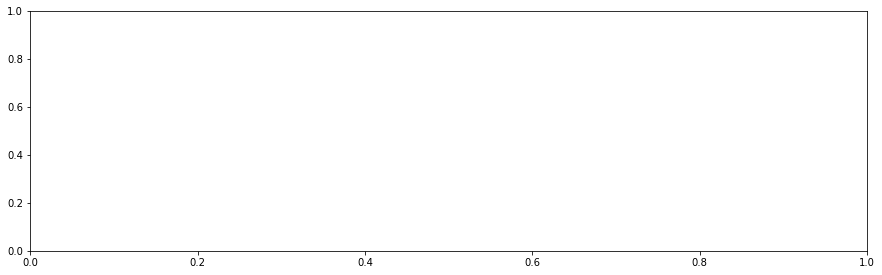

In [11]:
"""create and save plot of loss and metrics across epochs
"""
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['multif0_loss'])
plt.plot(history.history['melody_loss'])
plt.plot(history.history['bass_loss'])
plt.plot(history.history['vocal_loss'])
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend(['overall', 'multif0', 'melody', 'bass', 'vocal'], loc='upper left')

plt.subplot(3, 1, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_multif0_loss'])
plt.plot(history.history['val_melody_loss'])
plt.plot(history.history['val_bass_loss'])
plt.plot(history.history['val_vocal_loss'])
plt.title('Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('epoch')
plt.legend(['overall', 'multif0', 'melody', 'bass', 'vocal'], loc='upper left')

plt.subplot(3, 1, 3)
# plt.plot(history.history['val_soft_binary_accuracy'])
plt.plot(history.history['val_multif0_soft_binary_accuracy'])
plt.plot(history.history['val_melody_soft_binary_accuracy'])
plt.plot(history.history['val_bass_soft_binary_accuracy'])
plt.plot(history.history['val_vocal_soft_binary_accuracy'])
plt.title('soft_binary_accuracy')
plt.ylabel('soft_binary_accuracy')
plt.xlabel('epoch')
plt.legend(['multif0', 'melody', 'bass', 'vocal'], loc='upper left')


In [12]:
def get_single_test_prediction(model, npy_file=None, audio_file=None, max_frames=None):
    """Generate output from a model given an input numpy file
    """
    if npy_file is not None:
        input_hcqt = np.load(npy_file)
    elif audio_file is not None:
        input_hcqt = (C.compute_hcqt(audio_file)).astype(np.float32)
    else:
        raise ValueError("one of npy_file or audio_file must be specified")

    input_hcqt = input_hcqt.transpose(1, 2, 0)[np.newaxis, :, :, :]
    
    if max_frames is not None:
        input_hcqt = input_hcqt[:, :, :max_frames, :]

    n_t = input_hcqt.shape[2]
    n_slices = 2000
    t_slices = list(np.arange(0, n_t, n_slices))
    output_list = [[], [], [], []]
    for t in t_slices:
        prediction = model.predict(input_hcqt[:, :, t:t+n_slices, :])
        for i, pred in enumerate(prediction):
            output_list[i].append(prediction[i][0, :, :])

    predicted_output = [[], [], [], []]
    for i in range(len(output_list)):
        predicted_output[i] = np.hstack(output_list[i])

    return predicted_output, input_hcqt

MusicDelta_Reggae_MIX_input.npy


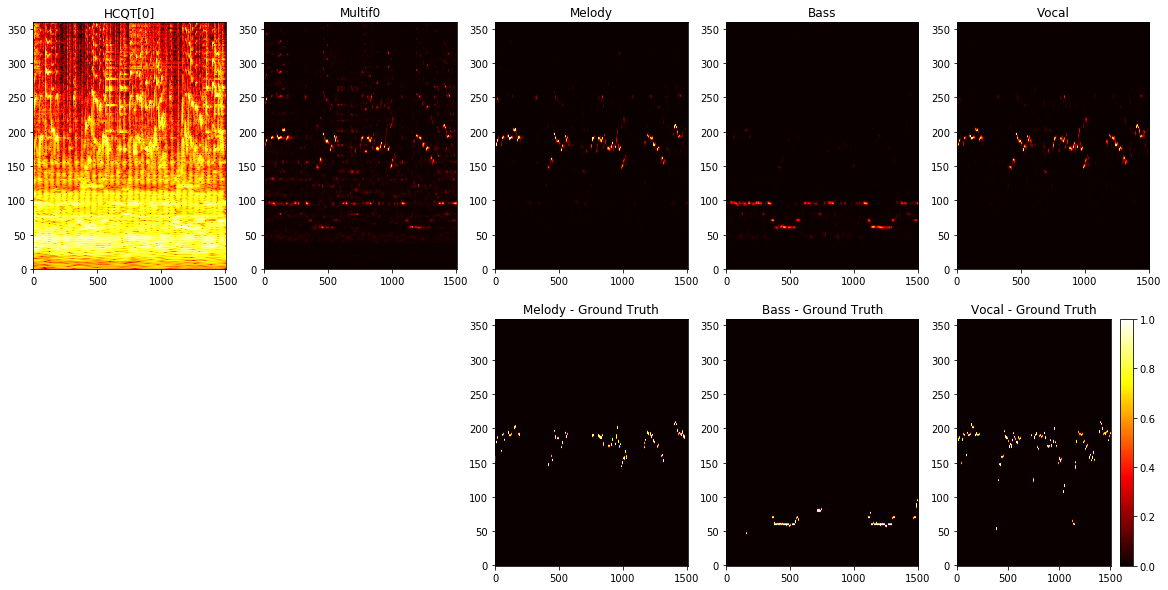

MusicDelta_SwingJazz_MIX_input.npy


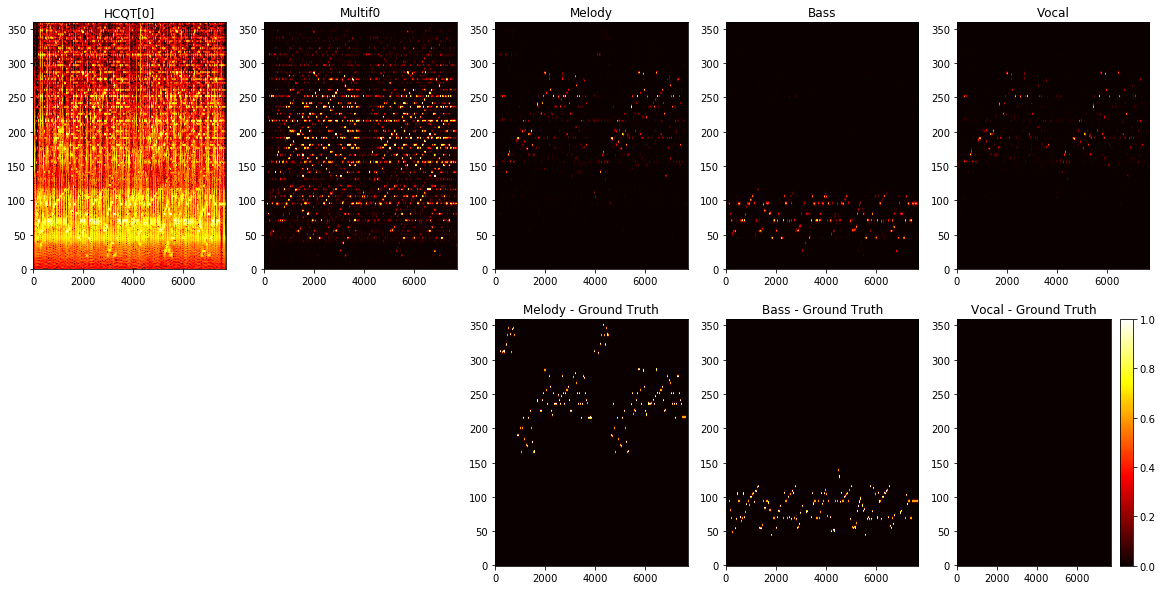

MatthewEntwistle_DontYouEver_MIX_input.npy


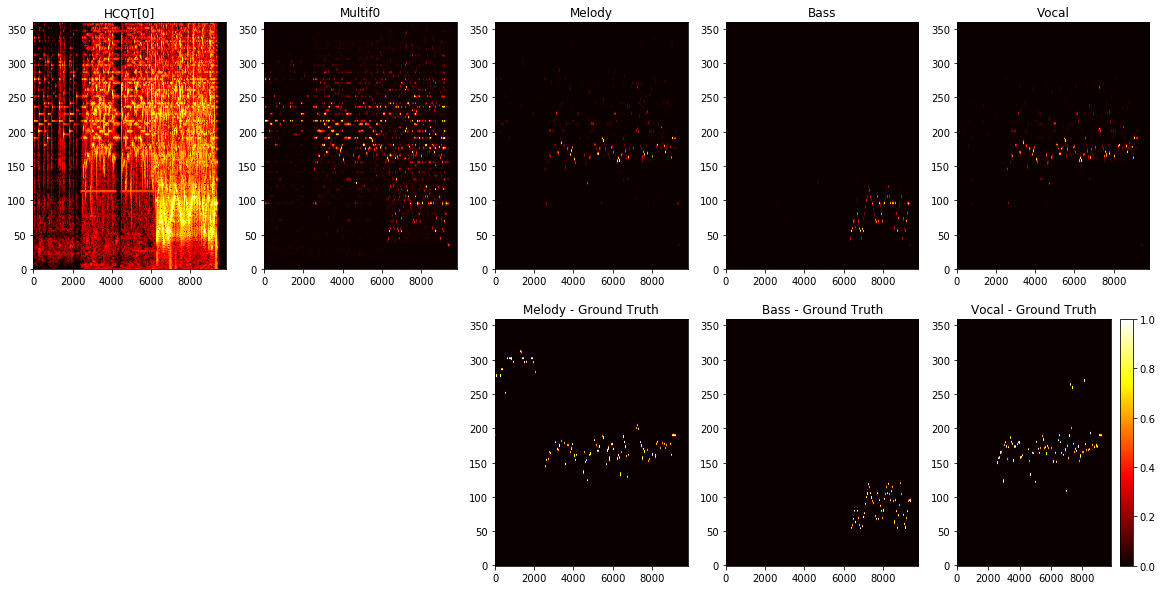

MusicDelta_LatinJazz_MIX_input.npy


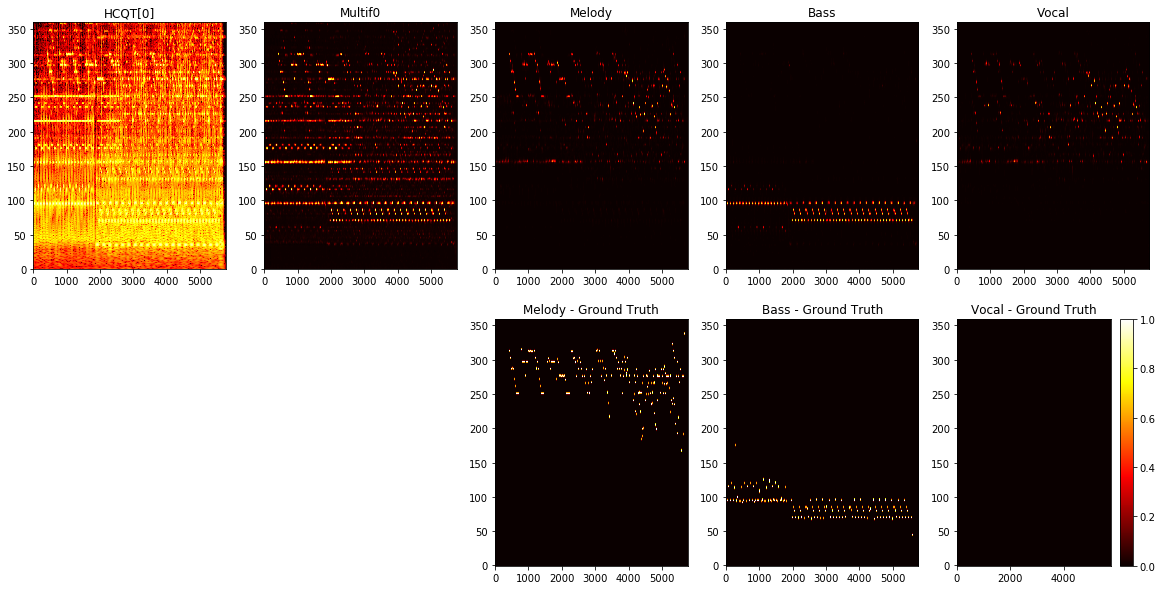

MusicDelta_GriegTrolltog_MIX_input.npy


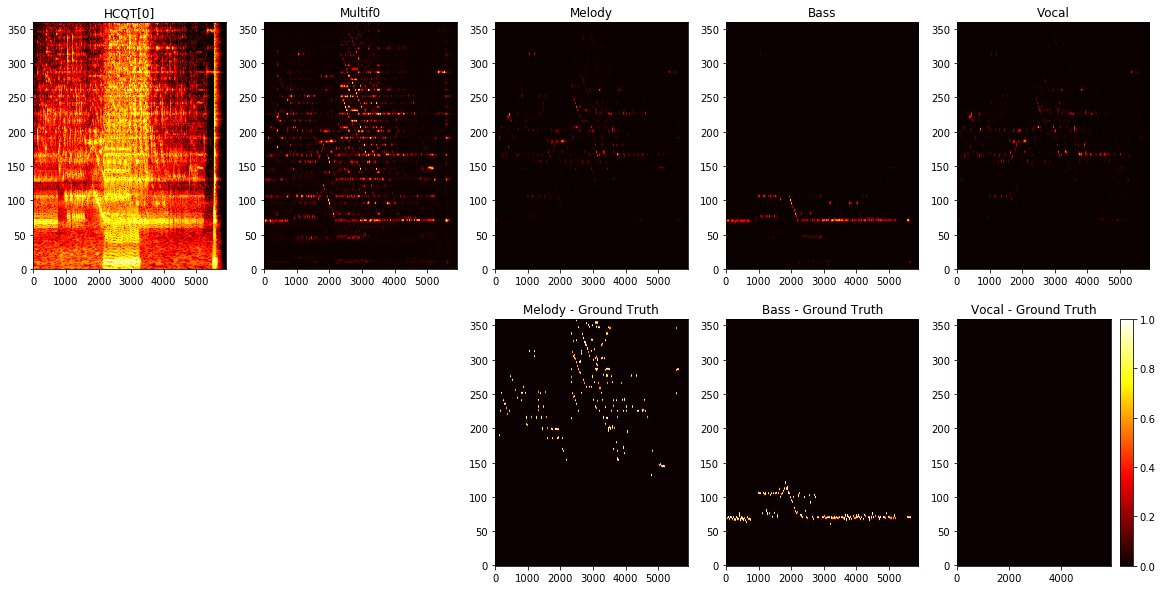

In [13]:
test_tracks = data_splits['test']
test_tracks = [
    'MusicDelta_Reggae', 'MusicDelta_SwingJazz',
    'MatthewEntwistle_DontYouEver', 'MusicDelta_LatinJazz',
    'MusicDelta_GriegTrolltog'
]
for track_id in test_tracks:
    
    json_fpath = "/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs/{}_XY_pairs.json".format(track_id)
    with open(json_fpath, 'r') as fhandle:
        dat = json.load(fhandle)
        
    npy_input_file = os.path.join(
        '/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs/{}_MIX_input.npy'.format(track_id))
    
    predicted_outputs, hcqt = get_single_test_prediction(model, npy_file=npy_input_file)
    
    dat_output = dat[npy_input_file]
    if 'multif0' in dat_output.keys():
        true_output_multif0 = np.load(dat_output['multif0'])
    else:
        true_output_multif0 = None
    if 'melody' in dat_output.keys():
        true_output_melody = np.load(dat_output['melody'])
    else:
        true_output_melody = None
    if 'bass' in dat_output.keys():
        true_output_bass = np.load(dat_output['bass'])
    else:
        true_output_bass = None
    if 'vocal' in dat_output.keys():
        true_output_vocal = np.load(dat_output['vocal'])
    else:
        true_output_vocal = None
    
    print(os.path.basename(npy_input_file))
    
    plt.figure(figsize=(20,10))

    plt.subplot(251)
    plt.title("HCQT[0]")
    plt.imshow(hcqt[0, :, :, 0], origin='lower', cmap='hot')
    plt.axis('tight')

    plt.subplot(252)
    plt.title("Multif0")
    plot_temp = predicted_outputs[0]
    plt.imshow(plot_temp, origin='lower', clim=[0, 1], cmap='hot')
    plt.axis('tight')
    
    if true_output_multif0 is not None:
        plt.subplot(257)
        plt.title("Multif0 - Ground Truth")
        plt.imshow(true_output_multif0, origin='lower', clim=[0, 1], cmap='hot')
        plt.axis('tight')

    plt.subplot(253)
    plt.title("Melody")
    plot_temp = predicted_outputs[1]
    plt.imshow(plot_temp, origin='lower', clim=[0, 1], cmap='hot')
    plt.axis('tight')

    if true_output_melody is not None:
        plt.subplot(258)
        plt.title("Melody - Ground Truth")
        plt.imshow(true_output_melody, origin='lower', clim=[0, 1], cmap='hot')
        plt.axis('tight')

    
    plt.subplot(254)
    plt.title("Bass")
    plot_temp = predicted_outputs[2]
    plt.imshow(plot_temp, origin='lower', clim=[0, 1], cmap='hot')
    plt.axis('tight')
    
    if true_output_bass is not None:
        plt.subplot(259)
        plt.title("Bass - Ground Truth")
        plt.imshow(true_output_bass, origin='lower', clim=[0, 1], cmap='hot')
        plt.axis('tight')
    
    plt.subplot(255)
    plt.title("Vocal")
    plot_temp = predicted_outputs[3]
    plt.imshow(plot_temp, origin='lower', clim=[0, 1], cmap='hot')
    plt.axis('tight')

    if true_output_vocal is not None:
        plt.subplot(2,5,10)
        plt.title("Vocal - Ground Truth")
        plt.imshow(true_output_vocal, origin='lower', clim=[0, 1], cmap='hot')
        plt.axis('tight')
    
    plt.colorbar()
    plt.show()

In [ ]:
from mir_eval import sonify
import compute_training_data as C
import scipy
from scipy.interpolate import interp1d

In [ ]:
def pitch_activations_to_mf0(pitch_activation_mat, thresh):
    """Convert a pitch activation map to multif0 by thresholding peak values
    at thresh
    """
    freqs = C.get_freq_grid()
    times = C.get_time_grid(pitch_activation_mat.shape[1])

    peak_thresh_mat = np.zeros(pitch_activation_mat.shape)
    peaks = scipy.signal.argrelmax(pitch_activation_mat, axis=0)
    peak_thresh_mat[peaks] = pitch_activation_mat[peaks]

    idx = np.where(peak_thresh_mat >= thresh)

    est_freqs = [[] for _ in range(len(times))]
    est_amps = [[] for _ in range(len(times))]
    for f, t in zip(idx[0], idx[1]):
        est_freqs[t].append(freqs[f])
        est_amps[t].append(pitch_activation_mat[f, t])

    est_freqs = [np.array(lst) for lst in est_freqs]
    return times, est_freqs, est_amps

def sonify_pitch_contour(times, frequencies, amplitudes, fs, length):
    fs = float(fs)

    if length is None:
        length = int(times.max() * fs)

    # Squash the negative frequencies.
    # wave(0) = 0, so clipping here will un-voice the corresponding instants
    frequencies = np.maximum(frequencies, 0.0)

    # Build a frequency interpolator
    f_interp = interp1d(times * fs, 2 * np.pi * frequencies / fs, kind='linear',
                        fill_value=0.0, bounds_error=False, copy=False)
    amp_interp = interp1d(times*fs, amplitudes, kind='linear', fill_value=0.0,
                          bounds_error=False, copy=False)
    
    # Estimate frequency at sample points
    f_est = f_interp(np.arange(length))
    a_est = amp_interp(np.arange(length))

    # Sonify the waveform
    return a_est * np.sin(np.cumsum(f_est))

In [ ]:
track_id = 'AClassicEducation_NightOwl'
npy_input_file = os.path.join(
        '/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs/{}_MIX_input.npy'.format(track_id))
predicted_outputs, hcqt = get_single_test_prediction(
    model, npy_file=npy_input_file, max_frames=4000)

for tag, pred in zip(['multif0', 'melody', 'bass', 'vocal'], predicted_outputs):
    print(tag)
    est_times, est_freqs, est_amps = pitch_activations_to_mf0(
        pred, 0.3
    )
    
    max_n_freqs = np.max([len(f) for f in est_freqs])
    stream_times = [[] for i in range(max_n_freqs)]
    stream_freqs = [[] for i in range(max_n_freqs)]
    stream_amps = [[] for i in range(max_n_freqs)]

    for t, freqs, amps in zip(est_times, est_freqs, est_amps):
        for i, (f, a) in enumerate(zip(freqs, amps)):
            stream_times[i].append(t)
            stream_freqs[i].append(f)
            stream_amps[i].append(a)

    freq_grid = C.get_freq_grid()
    time_grid = C.get_time_grid(hcqt.shape[2])
    time_bins = C.grid_to_bins(time_grid, 0.0, time_grid[-1])
    freq_bins = C.grid_to_bins(freq_grid, 0.0, freq_grid[-1])
  
    fs = 44100
    n_freqs = len(freq_grid)
    n_times = len(time_grid)
    
    length = int(time_grid[-1] * fs)
    y_synth = np.zeros((length, ))
    for stream_t, stream_f, stream_a in zip(stream_times, stream_freqs, stream_amps):
        
        time_idx = np.digitize(np.array(stream_t), time_bins) - 1
        freq_idx = np.digitize(np.array(stream_f), freq_bins) - 1
        
        idx = time_idx < n_times
        time_idx = time_idx[idx]
        freq_idx = freq_idx[idx]

        idx2 = freq_idx < n_freqs
        time_idx = time_idx[idx2]
        freq_idx = freq_idx[idx2]

        freqs_contour = np.zeros((n_times, ))
        amps_contour = np.zeros((n_times, ))
        for t, f, a in zip(time_idx, freq_idx, stream_a):
            freqs_contour[t] = freq_grid[f]
            amps_contour[t] = a
    
        y_temp = sonify_pitch_contour(
            time_grid, freqs_contour, amps_contour, fs, length=length
        )
        y_synth = y_synth + y_temp

    librosa.output.write_wav(
        "../outputs/{}_{}_synth_out.wav".format(track_id, tag),
        y_synth, 44100, norm=True
    )
    
    

In [ ]:
import sox
tfm = sox.Transformer()
for fpath in glob.glob("../outputs/{}*_synth_out.wav".format(track_id)):
    bname = os.path.basename(fpath).split('.')[0]
    tfm.build(fpath, os.path.join('../outputs', "{}.aiff".format(bname)))

In [14]:
track_id = 'MusicDelta_LatinJazz'
npy_file = os.path.join(
        '/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs/{}_MIX_input.npy'.format(track_id))
data = np.load(npy_file).transpose(1, 2, 0)[np.newaxis, :, :1500, :]

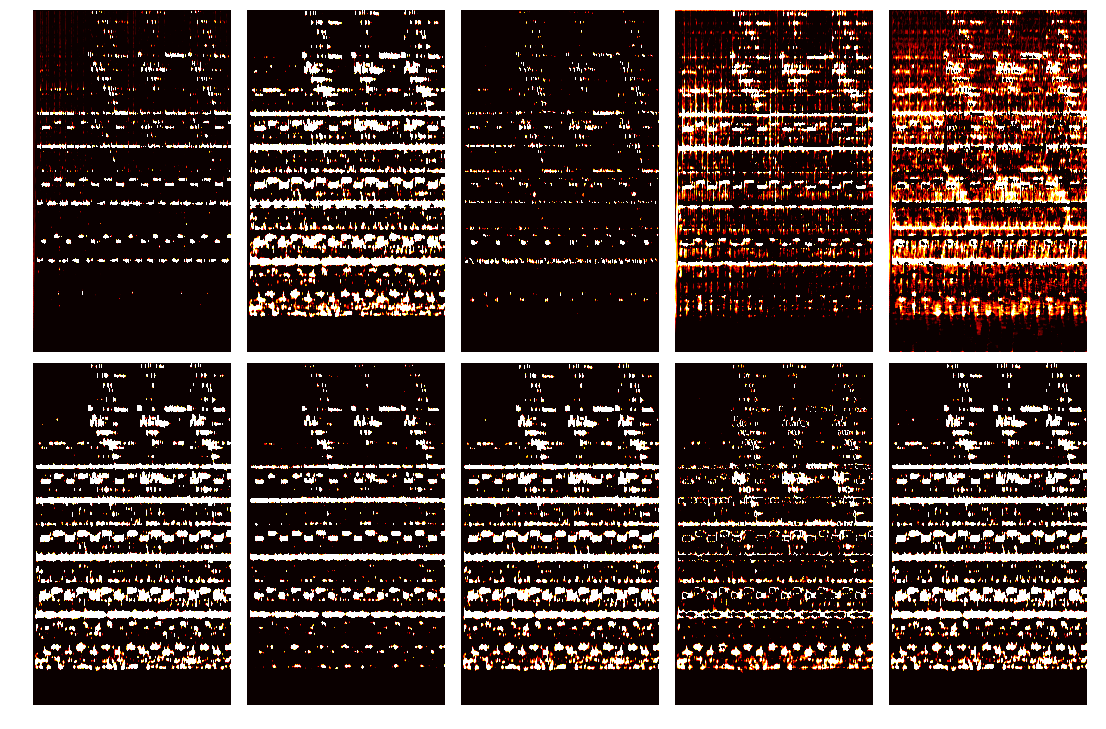

In [15]:
intermediate_layer = keras.models.Model(inputs=model.input,
                                 outputs=model.get_layer('bass_filters').output)
intermediate_output = intermediate_layer.predict(data)

plt.figure(figsize=(15, 10))
for i, layer in enumerate(range(10)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(intermediate_output[0, :, :, layer], origin='lower', cmap='hot', clim=[0, 1])
    plt.axis('tight')
    plt.axis('off')
plt.subplots_adjust(wspace=-8, hspace=-10)
plt.tight_layout()

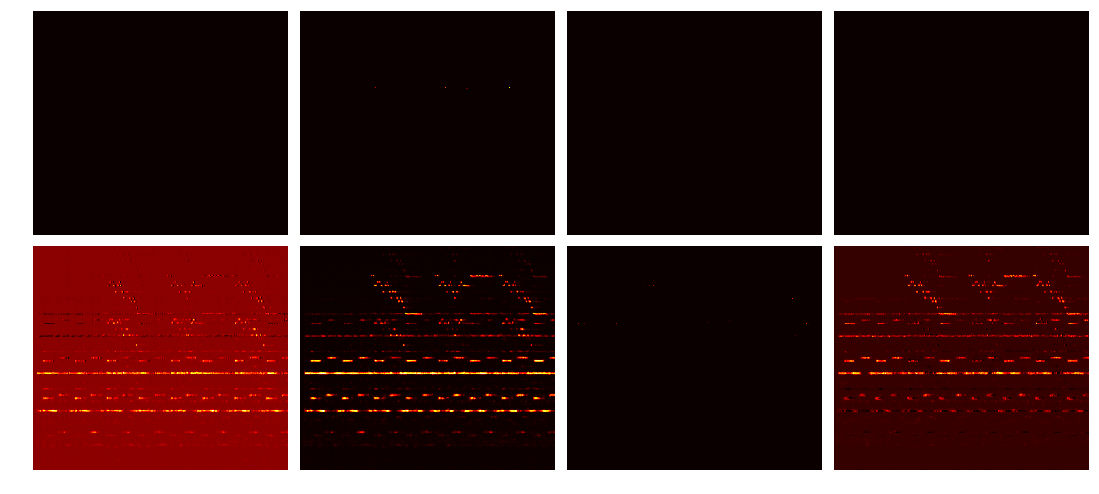

In [16]:
intermediate_layer = keras.models.Model(inputs=model.input,
                                 outputs=model.get_layer('timbre_layer1').output)
intermediate_output = intermediate_layer.predict(data)

plt.figure(figsize=(15, 10))
for i, layer in enumerate(range(24, 32)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(intermediate_output[0, :, :, layer], origin='lower', cmap='hot')
    plt.axis('tight')
    plt.axis('off')
plt.subplots_adjust(wspace=-8, hspace=-10)
plt.tight_layout()

In [ ]:
batch = train_generator.next()
hcqt = batch[0]
predicted_outputs = [batch[1]['multif0'], batch[1]['melody'], batch[1]['bass'], batch[1]['vocal']]
print(hcqt.shape)

plt.figure(figsize=(20,5))
idx = 0
plt.subplot(151)
plt.title("HCQT[0]")
plt.imshow(hcqt[idx, :, :, 0], origin='lower')
plt.axis('tight')

plt.subplot(152)
plt.title("Multif0")
plt.imshow(predicted_outputs[0][idx], origin='lower')
plt.axis('tight')

plt.subplot(153)
plt.title("Melody")
plt.imshow(predicted_outputs[1][idx], origin='lower')
plt.axis('tight')

plt.subplot(154)
plt.title("Bass")
plt.imshow(predicted_outputs[2][idx], origin='lower')
plt.axis('tight')

plt.subplot(155)
plt.title("Vocal")
plt.imshow(predicted_outputs[3][idx], origin='lower')
plt.axis('tight')

plt.show()

In [ ]:
predicted_outputs[2]

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(151)
plt.title("HCQT[0]")
plt.imshow(hcqt[0, :, :, 0], origin='lower')
plt.axis('tight')

plt.subplot(152)
plt.title("Multif0")
plt.imshow(predicted_outputs[0], origin='lower')
plt.axis('tight')

plt.subplot(153)
plt.title("Melody")
plt.imshow(predicted_outputs[1], origin='lower')
plt.axis('tight')

plt.subplot(154)
plt.title("Bass")
plt.imshow(predicted_outputs[2], origin='lower')
plt.axis('tight')

plt.subplot(155)
plt.title("Vocal")
plt.imshow(predicted_outputs[3], origin='lower')
plt.axis('tight')

plt.show()

In [ ]:
mel_distr = model.get_layer('vocal_filters2')

In [ ]:
weights = mel_distr.get_weights()

In [ ]:
plt.figure(figsize=(10, 30))
for i in range(32):
    plt.subplot(8, 4, i + 1)
    plt.imshow(weights[0][:, :, i, 0], origin='lower')
    plt.axis('auto')
